<a href="https://colab.research.google.com/github/xbaca8/2021-CAM-REU/blob/main/MSTAR_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q graphlearning

     |████████████████████████████████| 49 kB 2.3 MB/s 
     |████████████████████████████████| 646 kB 7.3 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 


In [ ]:
import urllib.request
import numpy as np
import graphlearning as gl

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

urllib.request.urlretrieve('http://www-users.math.umn.edu/~jwcalder/SAR10.npz','SAR10.npz')
M = np.load('SAR10.npz', allow_pickle=True)
hdr,fields,mag,phase = M['hdr'],M['fields'],M['mag'],M['phase']

In [ ]:
import imageio
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import torchvision.transforms as transforms

to_pil_image = transforms.ToPILImage()

def image_to_vid(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('generated_images.gif', imgs)

def save_reconstructed_images(recon_images, epoch):
    save_image(recon_images.cpu(), f"output{epoch}.jpg")

def save_loss_plot(train_loss, valid_loss):
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', label='train loss')
    plt.plot(valid_loss, color='red', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.jpg')
    plt.show()

In [ ]:
# Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torch.optim.lr_scheduler import StepLR
import matplotlib
from torchvision.utils import make_grid

matplotlib.style.use('ggplot')

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

# Loss function (POTENTIALLY CHANGE BCE TO NLL)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    train_loss = running_loss / counter 
    return train_loss

# Validation function
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data = data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction

    val_loss = running_loss / counter
    return val_loss, recon_images

In [ ]:
kernel_size = 3 # (3, 3) kernel
num_classes = 10
init_channels = 8 # initial number of filters
image_channels = 1
latent_dim = 32 # latent dimension for sampling

# define a Conv VAE
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=1, padding=1
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size, 
            stride=2, padding=1
        )
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64*11*11, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size, 
            stride=1, padding=0, output_padding=1, dilation=3
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, 
            stride=2, padding=0, output_padding=1, dilation=3
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size, 
            stride=2, padding=1, output_padding=1, dilation=1
        )
        self.droupout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x): #88
        # encoding
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        batch, _, _, _ = x.shape
        x = self.droupout1(x)
        x = x.reshape(batch, -1)
        hidden = self.fc1(x) #(64*11*11, 128)
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)
        z = z.view(-1, 64, 1, 1)
 
        # decoding
        x = F.relu(self.dec1(z)) #8
        x = F.relu(self.dec2(x)) #22
        x = self.droupout1(x)
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

    def encode(self, x):
        x = F.relu(self.enc1(x)) #88
        x = F.max_pool2d(x, 2) #44
        x = F.relu(self.enc2(x)) #44
        x = F.max_pool2d(x, 2) #22
        x = F.relu(self.enc3(x)) #22
        x = F.relu(self.enc4(x)) #11
        x = self.droupout1(x)
        x = x.reshape(x.shape[0], -1)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# initialize the model
model = CVAE().to(device)

# set the learning parameters
lr = 0.001
epochs = 50
batch_size = 64
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# a list to save all the reconstructed images in PyTorch grid format
grid_images = []

In [ ]:
#Convert targets to numerical labels
target = hdr[:,0].tolist()
classes = set(target)
label_dict = dict(zip(classes, np.arange(len(classes))))
labels = np.array([label_dict[t] for t in target],dtype=int)

#Training and testing split (based on papers)
angle = hdr[:,6].astype(int)
train_idx = angle == 17
test_idx = angle == 15

#Train testing split and convert to torch
data = torch.from_numpy(np.reshape(mag,(mag.shape[0],1,mag.shape[1],mag.shape[2]))).float()
#data = data / torch.max(data)
labels = torch.from_numpy(labels).long()
data_train = data[train_idx,:,:,:]
data_test = data[test_idx,:,:,:]
target_train = labels[train_idx]
target_test = labels[test_idx]

# Creating indexes for later graph learning use
all_indexes = np.arange(data.shape[0])
train_indexes_used = all_indexes[train_idx]
test_data_indexes = all_indexes[test_idx]

#Randomly shuffle training data
P = torch.randperm(np.sum(train_idx))
data_train = data_train[P,:,:,:]
target_train = target_train[P]

#Convert to torch dataloaders
dTr = data_train
dV = data_test
tTr = target_train
tV = target_test

SAR_train = MyDataset(dTr, tTr) 
trainloader = DataLoader(SAR_train, batch_size = batch_size, shuffle = True, **kwargs)

SAR_validate = MyDataset(dV, tV) 
testloader = DataLoader(SAR_validate, batch_size = batch_size, shuffle = True, **kwargs)

Epoch 1 of 50


  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
58it [00:02, 20.34it/s]                        
51it [00:00, 101.78it/s]                        


Train Loss: 268552.1420
Val Loss: 186381.6212
Epoch 2 of 50


58it [00:02, 24.93it/s]                        
51it [00:00, 102.90it/s]                        


Train Loss: 152257.6664
Val Loss: 126869.9474
Epoch 3 of 50


58it [00:02, 24.81it/s]                        
51it [00:00, 98.60it/s]                         

Train Loss: 122811.6847
Val Loss: 102941.7910
Epoch 4 of 50



58it [00:02, 24.92it/s]                        
51it [00:00, 100.37it/s]                        


Train Loss: 109501.4229
Val Loss: 98833.1666
Epoch 5 of 50


58it [00:02, 24.58it/s]                        
51it [00:00, 103.60it/s]                        


Train Loss: 107560.0450
Val Loss: 98165.9960
Epoch 6 of 50


58it [00:02, 24.53it/s]                        
51it [00:00, 104.98it/s]                        


Train Loss: 107027.4780
Val Loss: 97894.5048
Epoch 7 of 50


58it [00:02, 24.24it/s]                        
51it [00:00, 100.65it/s]                        

Train Loss: 106762.0915
Val Loss: 97808.5524
Epoch 8 of 50



58it [00:02, 25.10it/s]                        
51it [00:00, 100.98it/s]                        

Train Loss: 106554.0133
Val Loss: 97719.6309
Epoch 9 of 50



58it [00:02, 24.02it/s]                        
51it [00:00, 104.37it/s]                        


Train Loss: 106389.5810
Val Loss: 97462.1050
Epoch 10 of 50


58it [00:02, 25.03it/s]                        
51it [00:00, 102.44it/s]                        


Train Loss: 106243.1218
Val Loss: 97424.8832
Epoch 11 of 50


58it [00:02, 24.49it/s]                        
51it [00:00, 101.48it/s]                        


Train Loss: 106082.4340
Val Loss: 97470.3540
Epoch 12 of 50


58it [00:02, 24.87it/s]                        
51it [00:00, 100.52it/s]                        


Train Loss: 105966.4172
Val Loss: 97311.7919
Epoch 13 of 50


58it [00:02, 24.32it/s]                        
51it [00:00, 103.61it/s]                        


Train Loss: 105844.6174
Val Loss: 97267.4231
Epoch 14 of 50


58it [00:02, 24.78it/s]                        
51it [00:00, 100.93it/s]                        


Train Loss: 105735.4814
Val Loss: 97299.7061
Epoch 15 of 50


58it [00:02, 24.42it/s]                        
51it [00:00, 97.69it/s]                         

Train Loss: 105658.7376
Val Loss: 97199.4239
Epoch 16 of 50



58it [00:02, 25.54it/s]                        
51it [00:00, 101.00it/s]                        

Train Loss: 105581.7826
Val Loss: 97179.6441
Epoch 17 of 50



58it [00:02, 24.89it/s]                        
51it [00:00, 102.27it/s]                        


Train Loss: 105509.1864
Val Loss: 97207.6191
Epoch 18 of 50


58it [00:02, 24.71it/s]                        
51it [00:00, 105.12it/s]                        


Train Loss: 105444.4370
Val Loss: 97168.9446
Epoch 19 of 50


58it [00:02, 24.55it/s]                        
51it [00:00, 98.35it/s]                         


Train Loss: 105406.5315
Val Loss: 97223.9013
Epoch 20 of 50


58it [00:02, 25.00it/s]                        
51it [00:00, 99.77it/s]                         

Train Loss: 105361.2344
Val Loss: 97085.9840
Epoch 21 of 50



58it [00:02, 24.55it/s]                        
51it [00:00, 104.45it/s]                        


Train Loss: 105326.4676
Val Loss: 97146.8771
Epoch 22 of 50


58it [00:02, 25.19it/s]                        
51it [00:00, 104.58it/s]                        


Train Loss: 105296.3382
Val Loss: 97174.9538
Epoch 23 of 50


58it [00:02, 24.57it/s]                        
51it [00:00, 98.58it/s]                         

Train Loss: 105270.7937
Val Loss: 97135.6366
Epoch 24 of 50



58it [00:02, 25.12it/s]                        
51it [00:00, 100.48it/s]                        


Train Loss: 105248.4102
Val Loss: 97148.8737
Epoch 25 of 50


58it [00:02, 24.51it/s]                        
51it [00:00, 105.56it/s]                        


Train Loss: 105218.5407
Val Loss: 97028.4465
Epoch 26 of 50


58it [00:02, 25.04it/s]                        
51it [00:00, 103.60it/s]                        


Train Loss: 105200.3652
Val Loss: 96936.9993
Epoch 27 of 50


58it [00:02, 24.39it/s]                        
51it [00:00, 98.49it/s]                        

Train Loss: 105169.4184
Val Loss: 97067.7901
Epoch 28 of 50



58it [00:02, 24.86it/s]                        
51it [00:00, 99.21it/s]                         

Train Loss: 105153.6053
Val Loss: 97075.2123
Epoch 29 of 50



58it [00:02, 24.50it/s]                        
51it [00:00, 103.00it/s]                        


Train Loss: 105132.7430
Val Loss: 97025.2908
Epoch 30 of 50


58it [00:02, 24.95it/s]                        
51it [00:00, 103.11it/s]                        


Train Loss: 105123.9200
Val Loss: 96985.7264
Epoch 31 of 50


58it [00:02, 24.52it/s]                        
51it [00:00, 95.95it/s]                        

Train Loss: 105100.5448
Val Loss: 97023.8912
Epoch 32 of 50



58it [00:02, 25.14it/s]                        
51it [00:00, 99.34it/s]                         

Train Loss: 105089.8136
Val Loss: 97053.6984
Epoch 33 of 50



58it [00:02, 24.78it/s]                        
51it [00:00, 103.28it/s]                        


Train Loss: 105063.1610
Val Loss: 96966.2576
Epoch 34 of 50


58it [00:02, 24.60it/s]                        
51it [00:00, 103.80it/s]                        


Train Loss: 105051.1583
Val Loss: 96957.0009
Epoch 35 of 50


58it [00:02, 24.12it/s]                        
51it [00:00, 100.72it/s]                        


Train Loss: 105026.6721
Val Loss: 97093.8152
Epoch 36 of 50


58it [00:02, 25.09it/s]                        
51it [00:00, 99.23it/s]                        

Train Loss: 104998.9407
Val Loss: 96953.7579
Epoch 37 of 50



58it [00:02, 24.44it/s]                        
51it [00:00, 102.05it/s]                        


Train Loss: 104971.5625
Val Loss: 96955.3383
Epoch 38 of 50


58it [00:02, 24.68it/s]                        
51it [00:00, 100.37it/s]                        


Train Loss: 104952.9937
Val Loss: 96845.9542
Epoch 39 of 50


58it [00:02, 24.60it/s]                        
51it [00:00, 100.20it/s]                        

Train Loss: 104925.5174
Val Loss: 96833.0913
Epoch 40 of 50



58it [00:02, 24.94it/s]                        
51it [00:00, 99.87it/s]                         

Train Loss: 104881.5329
Val Loss: 96850.1353
Epoch 41 of 50



58it [00:02, 24.56it/s]                        
51it [00:00, 104.42it/s]                        


Train Loss: 104858.5152
Val Loss: 96790.7775
Epoch 42 of 50


58it [00:02, 25.11it/s]                        
51it [00:00, 103.21it/s]                        


Train Loss: 104820.1522
Val Loss: 96795.2021
Epoch 43 of 50


58it [00:02, 24.12it/s]                        
51it [00:00, 101.34it/s]                        

Train Loss: 104801.8111
Val Loss: 96741.6154
Epoch 44 of 50



58it [00:02, 24.64it/s]                        
51it [00:00, 98.52it/s]                         

Train Loss: 104789.9230
Val Loss: 96620.6133
Epoch 45 of 50



58it [00:02, 24.24it/s]                        
51it [00:00, 102.03it/s]                        


Train Loss: 104761.9244
Val Loss: 96802.8133
Epoch 46 of 50


58it [00:02, 24.43it/s]                        
51it [00:00, 101.61it/s]                        


Train Loss: 104725.3432
Val Loss: 96719.3108
Epoch 47 of 50


58it [00:02, 24.60it/s]                        
51it [00:00, 98.52it/s]                         


Train Loss: 104720.7726
Val Loss: 96822.7751
Epoch 48 of 50


58it [00:02, 24.64it/s]                        
51it [00:00, 99.24it/s]                         

Train Loss: 104704.1946
Val Loss: 96645.8038
Epoch 49 of 50



58it [00:02, 24.27it/s]                        
51it [00:00, 103.03it/s]                        


Train Loss: 104675.4570
Val Loss: 96588.2853
Epoch 50 of 50


58it [00:02, 24.94it/s]                        
51it [00:00, 102.07it/s]                        


Train Loss: 104664.9913
Val Loss: 96634.8196


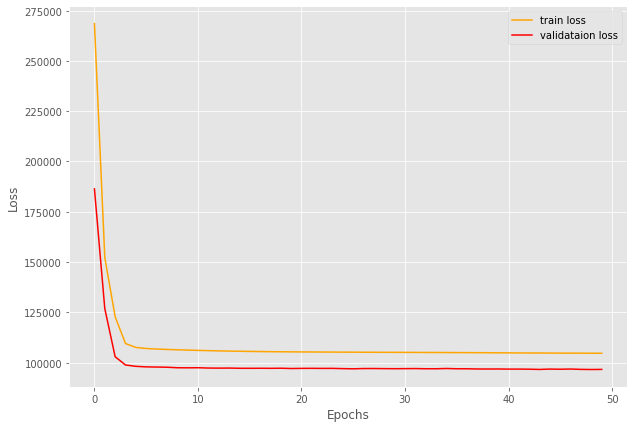

TRAINING COMPLETE


In [ ]:
train_loss = []
valid_loss = []
batch_size = 64

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    train_epoch_loss = train(
        model, trainloader, SAR_train, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, testloader, SAR_validate, device, criterion
    )

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)

    # save the reconstructed images from the validation loop
    save_reconstructed_images(recon_images, epoch+1)

    # convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")

# save the reconstructions as a .gif file
image_to_vid(grid_images)

# save the loss plots to disk
save_loss_plot(train_loss, valid_loss)
print('TRAINING COMPLETE')

In [ ]:
#Save model
torch.save(model.state_dict(), 'SAR10_cvae.pt')

CVAE_data = data

#Encode the dataset and save to npz file
with torch.no_grad():
    mu = model.encode(CVAE_data.to(device))
    Y = mu.cpu().numpy()
    np.savez_compressed('SAR10_cvae.npz',data=Y,labels=labels)

In [ ]:
M = np.load('SAR10_cvae.npz')
X = M['data']   #Encoded data
L = M['labels'] #Labels

print(X.shape)
print(L.shape)

W_cvae = gl.knn_weight_matrix(20,data=X)

(6874, 7744)
(6874,)
kNN search with Annoy approximate nearest neighbor package...
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [ ]:
test_set_labels = L[test_data_indexes]
sum = 0
num_train_per_class = 50

for i in range(20):

  train_ind = gl.randomize_labels(L, num_train_per_class) #use angle=17 train labels
  train_labels = L[train_ind]

  #Run Laplace learning
  laplace_labels = gl.graph_ssl(W_cvae,train_ind,train_labels,algorithm='laplace')

  test_set_laplace_labels = laplace_labels[test_data_indexes]
  #print(gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind)))
  sum += gl.accuracy(test_set_laplace_labels,test_set_labels,len(train_ind))

average = sum / 20
print('Average Test Accuracy:', average)

Average Test Accuracy:  95.45874953755087
